In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Data/adult.data', header=None, skipinitialspace=True)
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',\
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',\
                'native country', 'income']

data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Missing values are denoted as '?' in the data.
# We can see there are a few columns that are missing data.
data.replace('?', np.nan, inplace=True)
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native country     583
income               0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
IGNORE_COLS = ['fnlwgt'] # We will test this later, but for now I suspect this will just mess up the data.
NUM_COLS = []
CHAR_COLS = []
# We should convert the objects to categorical
for col in data.columns:
    if col in IGNORE_COLS:
        continue
        
    if data[col].dtype == 'object':
        CHAR_COLS.append(col)
        data[col] = data[col].astype('category')
        print(data[col].value_counts(dropna=False))
    else:
        NUM_COLS.append(col)

data.info()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
NaN                  1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         377

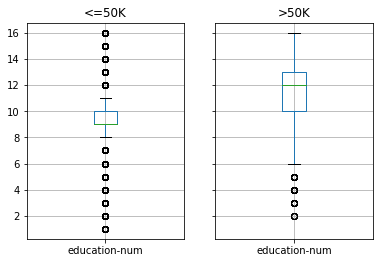

In [6]:
income_by_education = data[['income', 'education-num']].groupby('income')
bp = income_by_education.boxplot()
# Not surprisingly, we can see that those who make >50k a year have more years of education
# I kinda want to expand this a bit

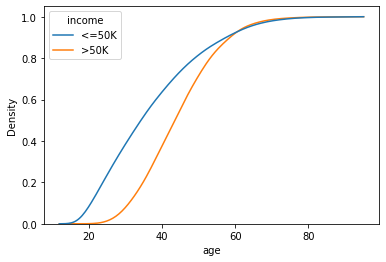

In [18]:
sns.kdeplot(data=data[NUM_COLS + ['income']], x='age', hue='income',\
            cumulative=True, common_norm=False, common_grid=True)

In [11]:
data[['age', 'income']]

,age,income
0,39,<=50K
1,50,<=50K
2,38,<=50K
3,53,<=50K
4,28,<=50K
...,...,...
32556,27,<=50K
32557,40,>50K
32558,58,<=50K
32559,22,<=50K


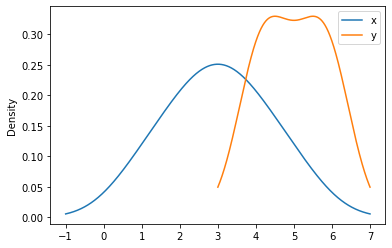

In [82]:
df = pd.DataFrame({
    'x': [1, 2, 2.5, 3, 3.5, 4, 5],
    'y': [4, 4, 4.5, 5, 5.5, 6, 6],
})
ax = df.plot.kde()

In [100]:
data[CHAR_COLS]

,workclass,education,marital-status,occupation,relationship,race,sex,native country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States,<=50K
